In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sts

import arviz as av
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import mcx
import mcx.distributions as dist

# sns.set_style("darkgrid")
# Trigger the warning about missing GPUs
jnp.ones(1);

/home/elantkom/.cache/pypoetry/virtualenvs/rethinking-7skSNelE-py3.8/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Code 2.1

In [2]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

# Figure 2.5

Note: we use the grid approximation method from [Code 2.3](#Code-2.3) 

In [3]:
def plot_prior_and_posterior(x, prior, posterior, tossing_results, ax):
    ax = sns.lineplot(
        x=x, y=prior, ax=ax, color="black", alpha=0.5, linestyle="dashed"
    )
    
    ax = sns.lineplot(
        x=x, y=posterior, ax=ax, color="black"
    )

    ax.set_title(' '.join(list(tossing_results)))
    ax.set_yticks([])
    
    return ax

In [4]:
tosses = "WLWWWLWLW"
grid_size = 10000

p_grid = jnp.linspace(0, 1, grid_size)

In [5]:
def _make_figure_2_5(use_updated_prior: bool = False):
    
    # matplotlib
    fig, axes = plt.subplots(3, 3, figsize=(10, 10), dpi=256)
    axes = axes.flatten()

    # we start with a flat prior
    static_prior  = jnp.ones(grid_size) / grid_size
    updated_prior = static_prior.copy()

    # Generate plot each time when we add a new sample
    for i, ax in enumerate(axes, 1):

        # Pretend we observed only `i` samples
        observed = tosses[:i]
        
        # Infer the parameters of the binomial distro
        n = len(observed)
        k = observed.count("W")

        # Build the distro and get the likelihood of the data
        binom = dist.Binomial(p=p_grid, n=n)
        likelihood = jnp.exp(binom.logpdf(k))

        # Depending on the flag we can either reproduce the textbook bug, or 
        # generate the correct figure
        if use_updated_prior:
            prior = updated_prior
        else:
            prior = static_prior
        
        posterior = likelihood * prior
        posterior /= posterior.sum()

        # Add the next plot to the grid
        plot_prior_and_posterior(
            x=p_grid, 
            prior=updated_prior, 
            posterior=posterior, 
            tossing_results=observed, 
            ax=ax
        )

        # Update the prior
        updated_prior = posterior

    plt.tight_layout()

### Textbook version

Note: there seem to be an error in the text, the prior is not updated

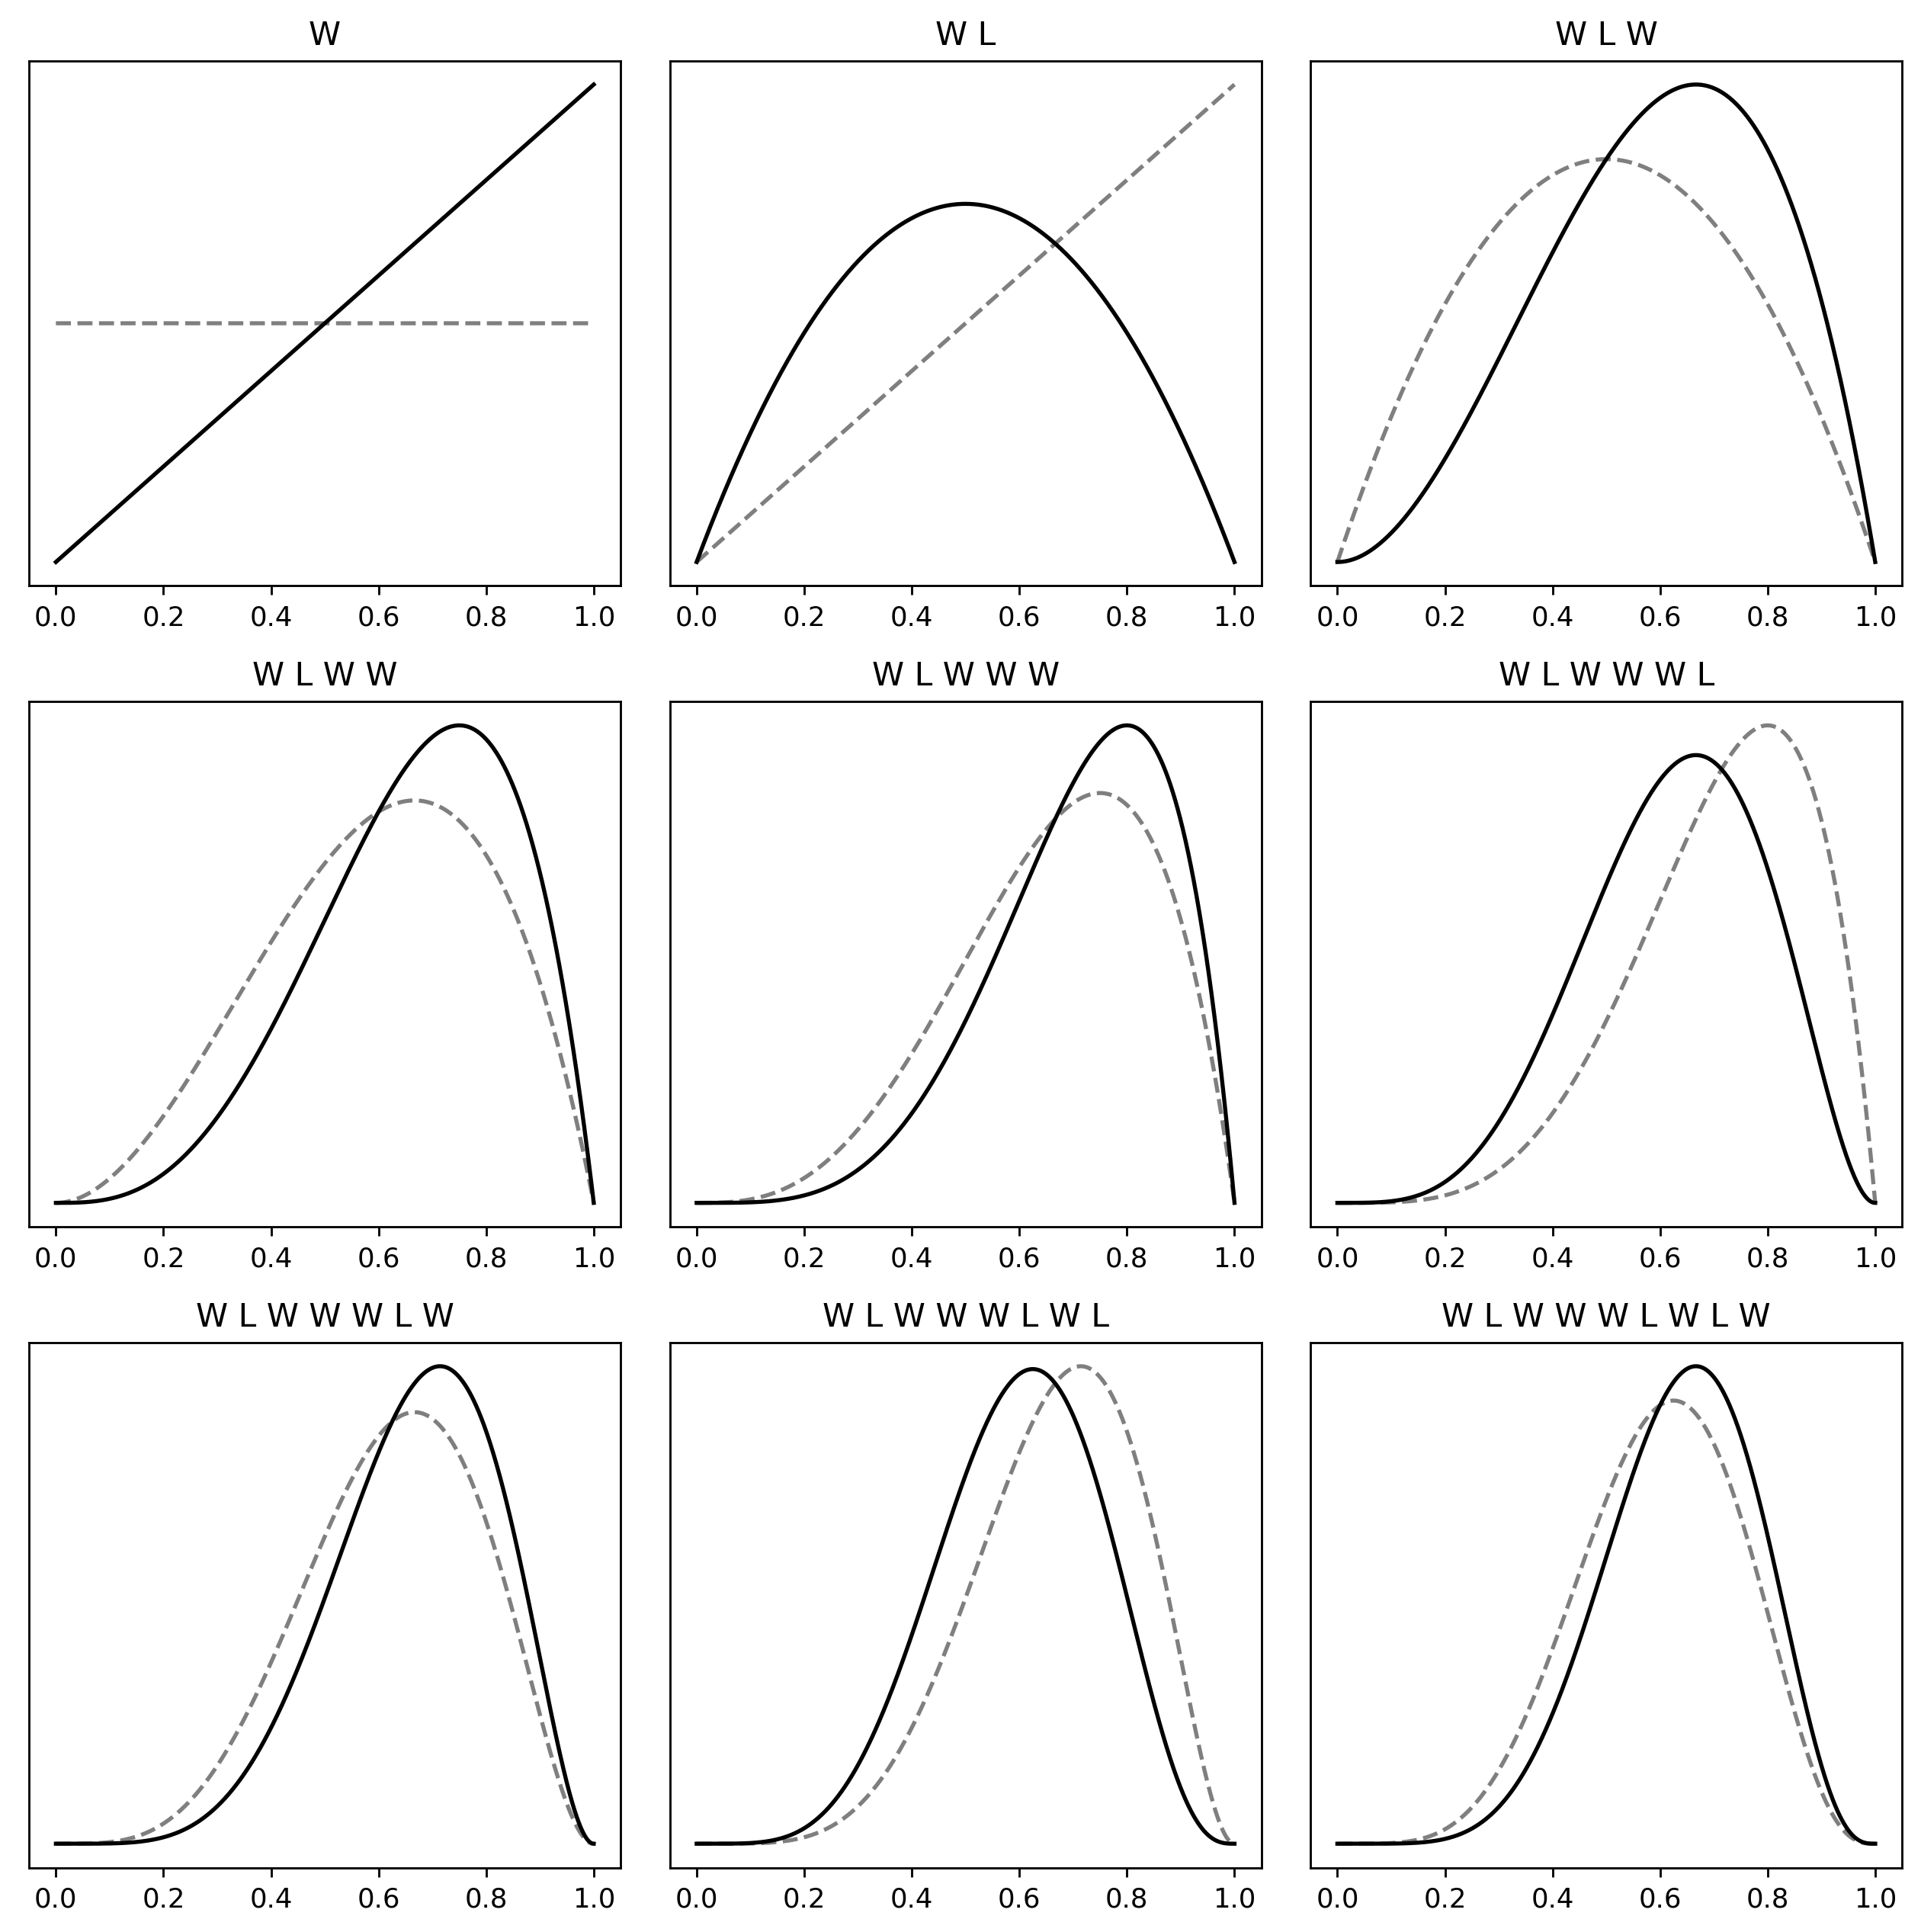

In [6]:
_make_figure_2_5(use_updated_prior=False)

### Fixed version

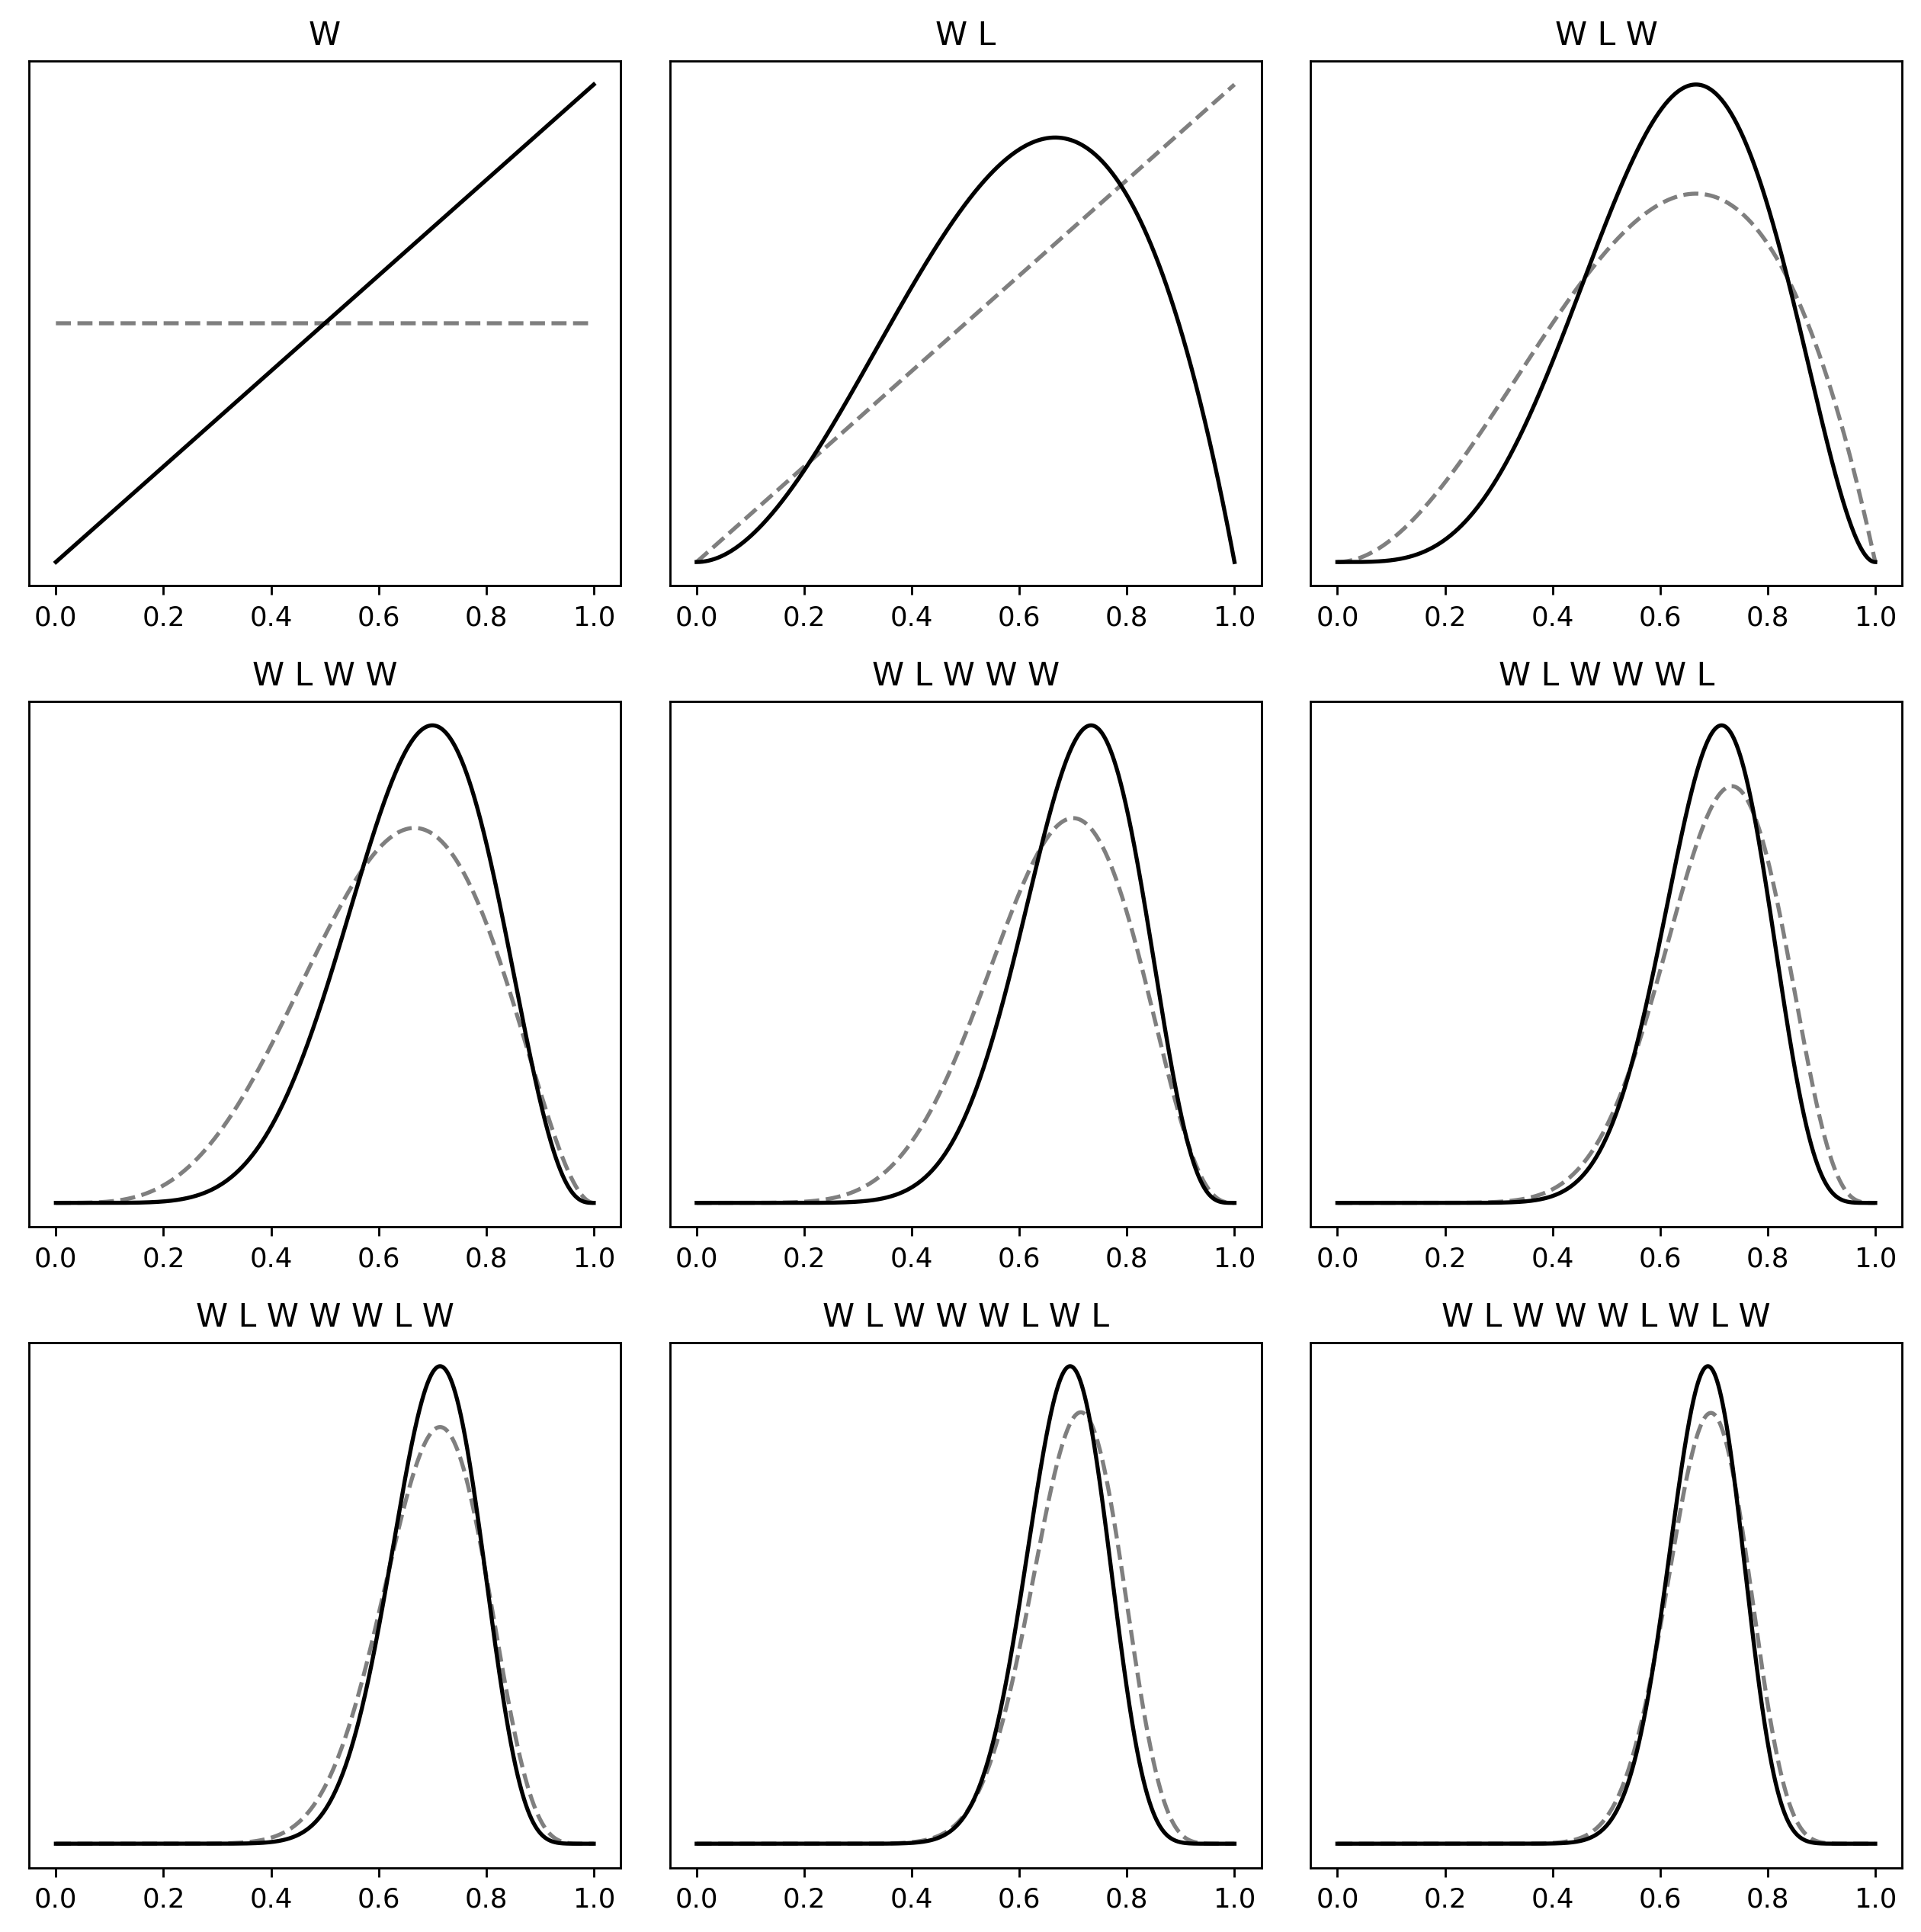

In [7]:
_make_figure_2_5(use_updated_prior=True)

# Code 2.2

In [8]:
binom = dist.Binomial(p=0.5, n=9)
log_p = binom.logpdf(6)
p = jnp.exp(log_p)

float(p)

0.16406309604644775

# Figure 2.6 (sort of)

In [9]:
tosses = "WLWWWLWLW"
grid_size = 10000

n = len(tosses)
k = tosses.count("W")

p_grid = jnp.linspace(0, 1, grid_size)

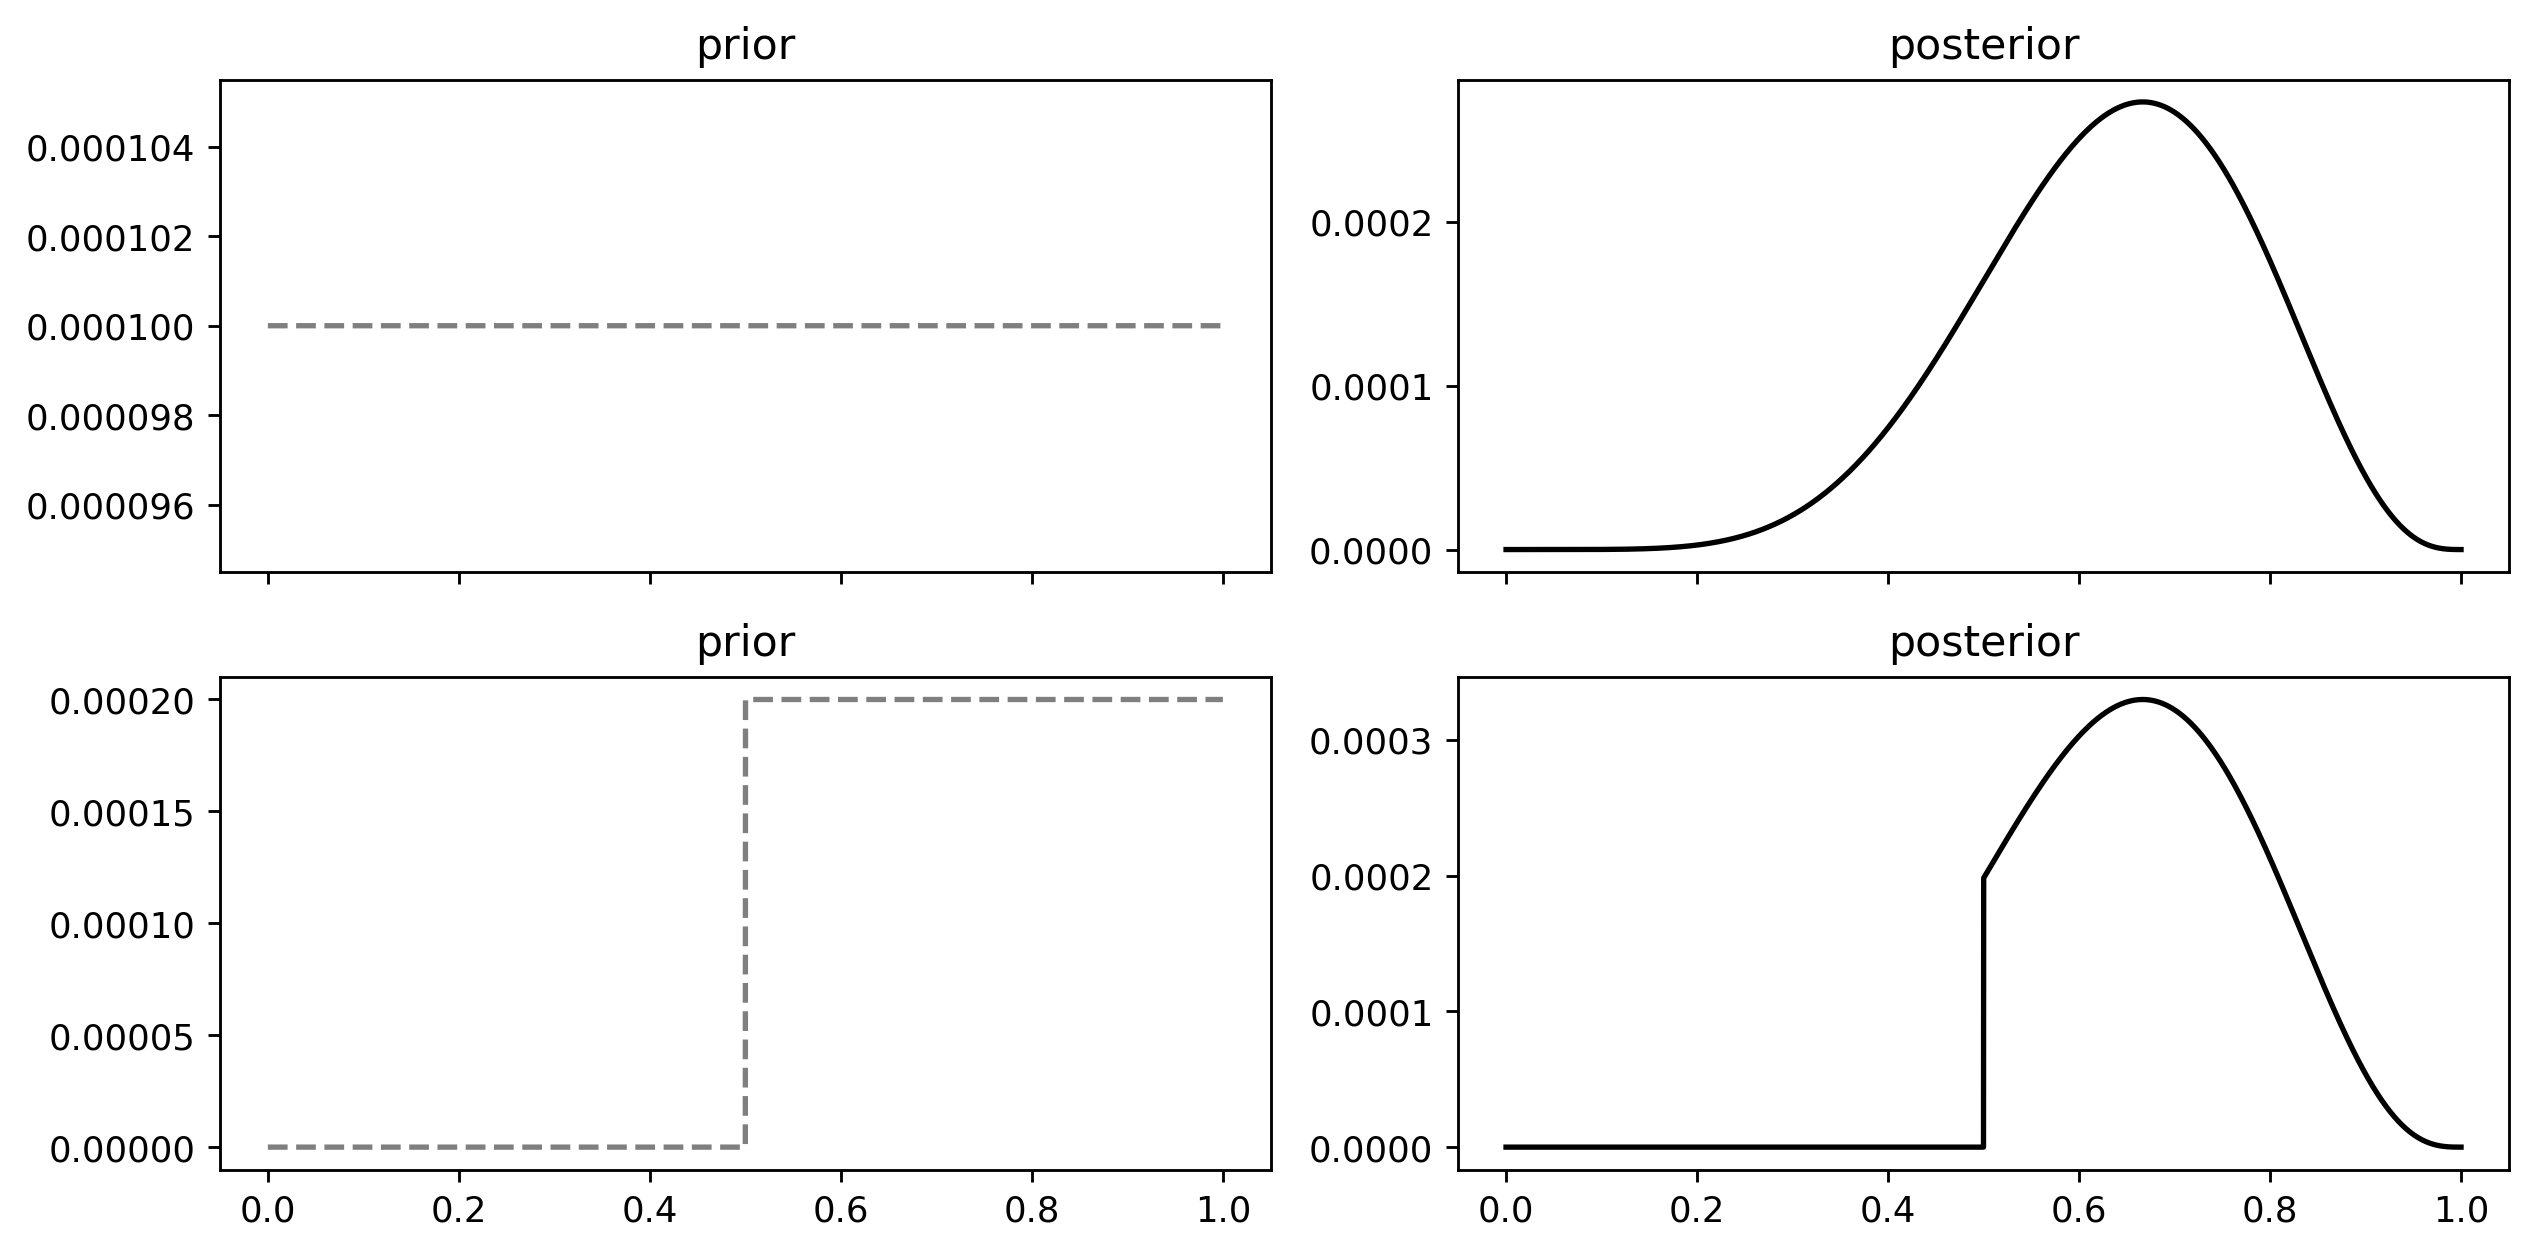

In [10]:
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(10, 5), dpi=256, sharex=True, sharey=False)
    
binom = dist.Binomial(p=p_grid, n=n)
likelihood = jnp.exp(binom.logpdf(k))
    
# TOP
prior = jnp.ones(grid_size) / grid_size
posterior = likelihood * prior
posterior /= posterior.sum()

ax00 = sns.lineplot(x=p_grid, y=prior, ax=ax00, color="black", alpha=0.5, linestyle="dashed")
ax01 = sns.lineplot(x=p_grid, y=posterior, ax=ax01, color="black")
ax00.set_title("prior")
ax01.set_title("posterior")

# BOTTOM
prior = jnp.concatenate((
    jnp.zeros(grid_size // 2),
    jnp.ones(grid_size // 2)
))
prior = prior / prior.sum()
posterior = likelihood * prior
posterior /= posterior.sum()

ax10 = sns.lineplot(x=p_grid, y=prior, ax=ax10, color="black", alpha=0.5, linestyle="dashed")
ax11 = sns.lineplot(x=p_grid, y=posterior, ax=ax11, color="black")
ax10.set_title("prior")
ax11.set_title("posterior")

# pyplot stuff
plt.tight_layout()

# Code 2.3

Note: we've already done this for the plots above

In [11]:
def grid_approx_posterior(grid_size, prior: jnp.DeviceArray = None):
    
    # define grid
    p_grid = jnp.linspace(0, 1, grid_size)

    # define prior
    if prior is None:
        prior = jnp.ones(grid_size) / grid_size

    # compute likelihood at each value in grid
    binom = dist.Binomial(p=p_grid, n=9)
    likelihood = jnp.exp(binom.logpdf(6))

    # compute product of likelihood and prior
    posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior /= posterior.sum()
    
    return p_grid, posterior

# Code 2.4 & Figure 2.7

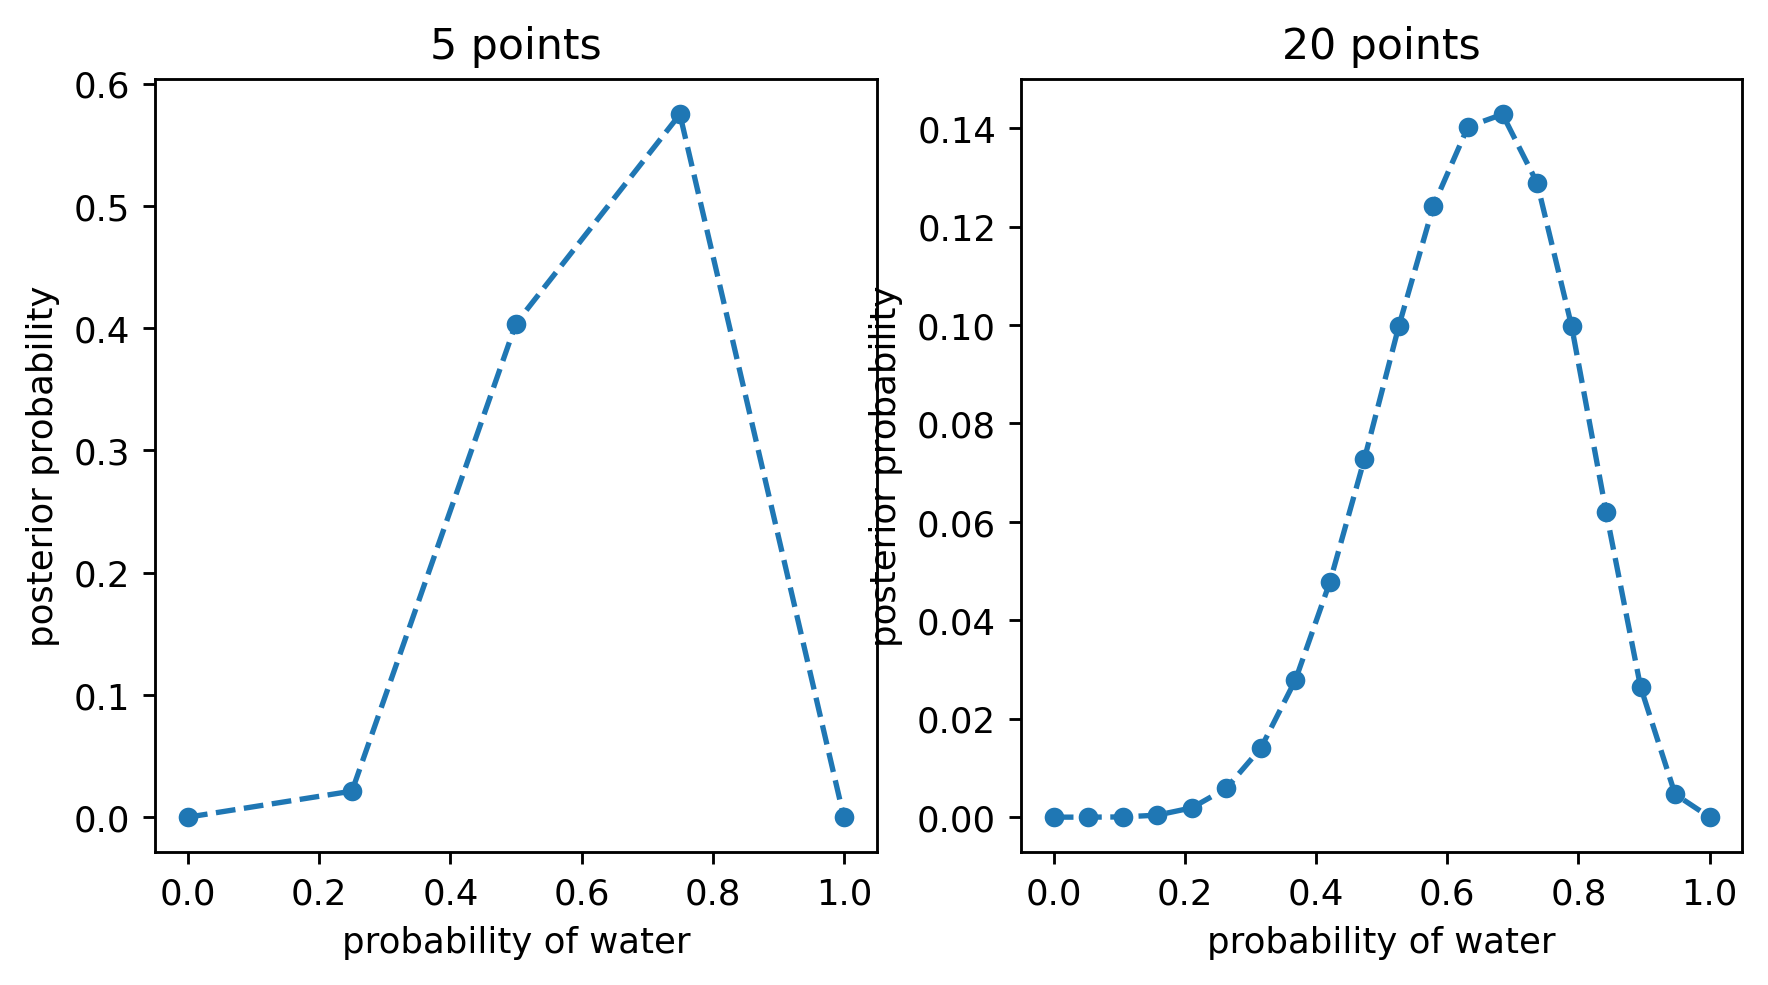

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=256)

for grid_size, ax in zip([5, 20], axes):
    
    grid, posterior = grid_approx_posterior(grid_size)
    
    ax = sns.lineplot(x=grid, y=posterior, ax=ax, linestyle="dashed")
    ax = sns.scatterplot(x=grid, y=posterior, ax=ax, marker="o")
    
    ax.set_title(f"{grid_size} points")
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")

# Code 2.5

In [13]:
p_grid = jnp.linspace(0, 1, 20)

priors = [
    (p_grid > 0.5).astype(jnp.float32),
    jnp.exp(-5 * jnp.abs(p_grid - 0.5))
]

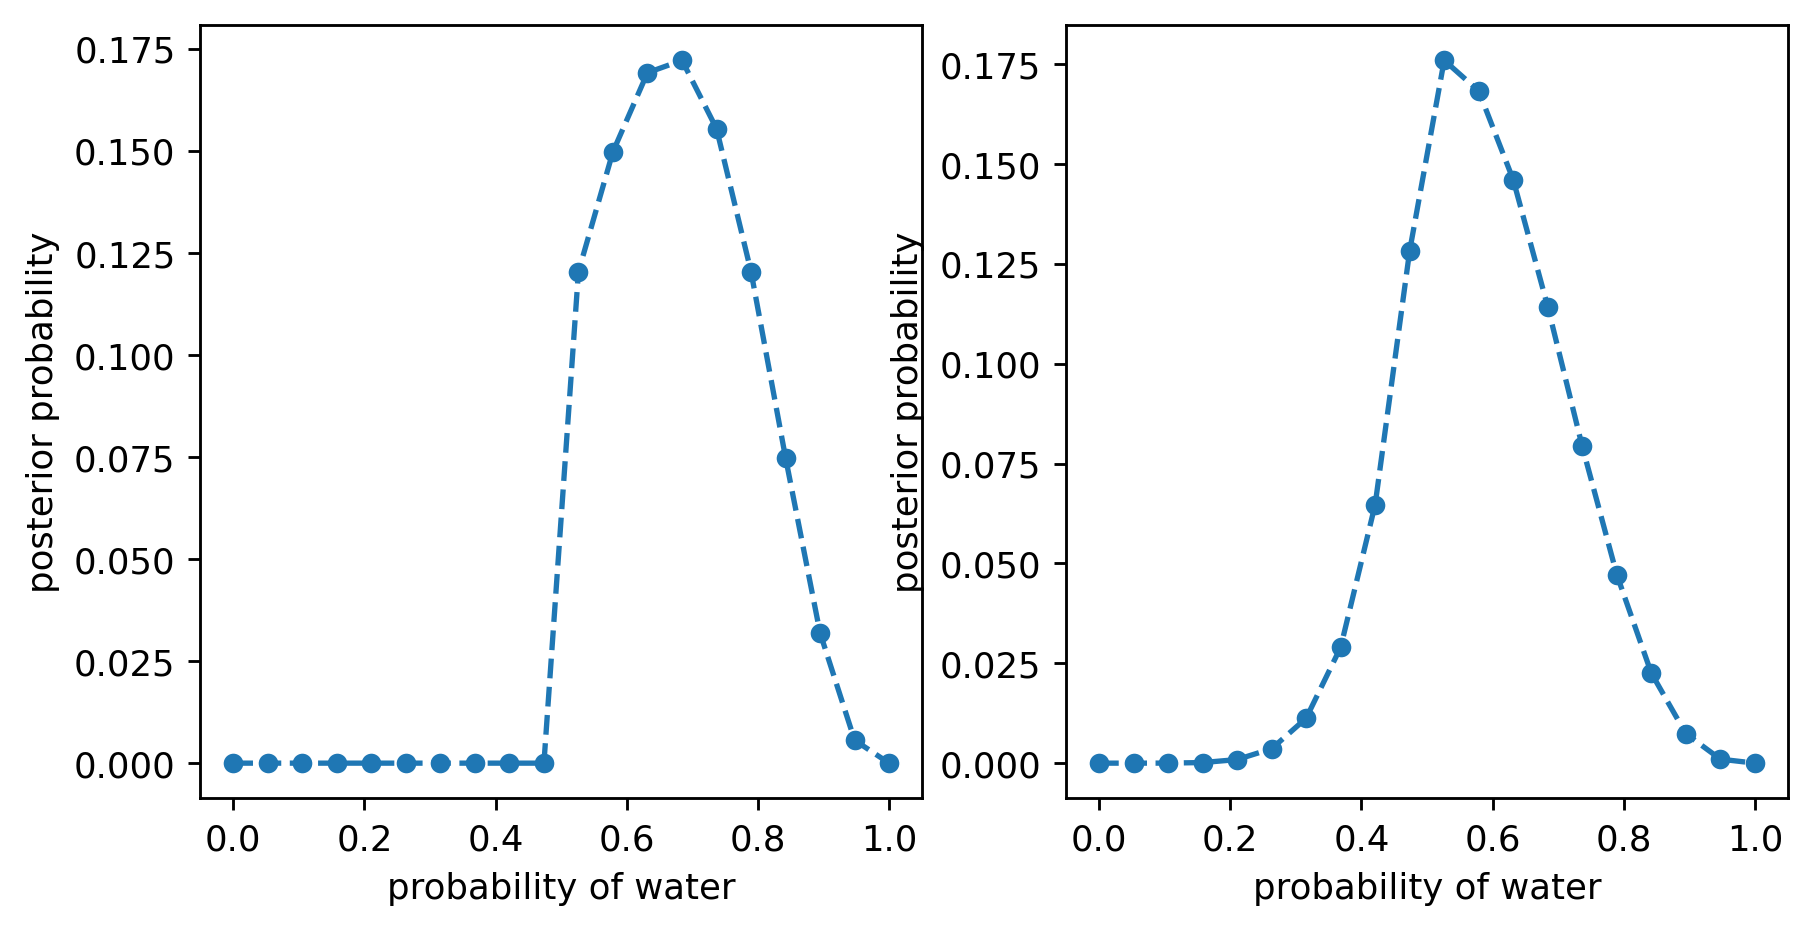

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=256)

for prior, ax in zip(priors, axes):
    
    grid, posterior = grid_approx_posterior(grid_size=len(prior), prior=prior)
    
    ax = sns.lineplot(x=grid, y=posterior, ax=ax, linestyle="dashed")
    ax = sns.scatterplot(x=grid, y=posterior, ax=ax, marker="o")
    
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")

# Code 2.6

In [15]:
from functools import partial
from scipy.optimize import minimize

In [16]:
@mcx.model
def model():
    p <~ dist.Uniform(0, 1)
    W <~ dist.Binomial(p, 9)
    
    return W

In [17]:
def jax_loss_fn(p):
    return -model.logpdf(W=6, p=p)


def py_loss_fn(p):
    jax_obj = jax_loss_fn(p)
    return float(jax_obj)


hessian_fn  = jax.hessian(jax_loss_fn)

In [18]:
mu = minimize(
    fun = py_loss_fn,
    x0  = 0.5,
    method = 'Nelder-Mead'
).x[0]

mu

0.6666992187500004

In [19]:
precision = hessian_fn(mu)
sigma = np.sqrt(float(1 / precision))

sigma

0.15712716532537604

# Code 2.7 & Figure 2.8 (left)

In [20]:
x = np.linspace(0, 1, 10_000)

quap_line = jnp.exp(dist.Normal(mu, sigma).logpdf(x))
true_line = jnp.exp(dist.Beta(6 + 1, 3 + 1).logpdf(x))

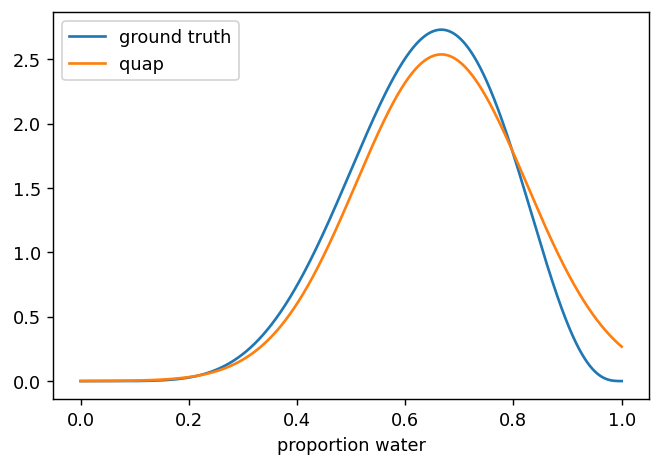

In [21]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=128)

ax = sns.lineplot(x=x, y=true_line, ax=ax)
ax = sns.lineplot(x=x, y=quap_line, ax=ax)
ax.legend(["ground truth", "quap"]);
ax.set_xlabel("proportion water");

# Code 2.8

In [22]:
N_SAMPLES = 10_000

In [23]:
%%time

samples = [0.5]

for i in range(1, N_SAMPLES):
    p_old = samples[i - 1]
    p_new = sts.norm(p_old, 0.1).rvs()

    p_new = p_new if (p_new > 0) else abs(p_new)
    p_new = p_new if (p_new < 1) else 2 - p_new

    q0 = sts.binom(n=9, p=p_old).pmf(k=6)
    q1 = sts.binom(n=9, p=p_new).pmf(k=6)

    accept = np.random.random() < (q1 / q0)
    new = p_new if accept else p_old

    samples.append(new)

samples = np.array(samples)

CPU times: user 20.7 s, sys: 19.9 ms, total: 20.7 s
Wall time: 20.7 s


# Code 2.9

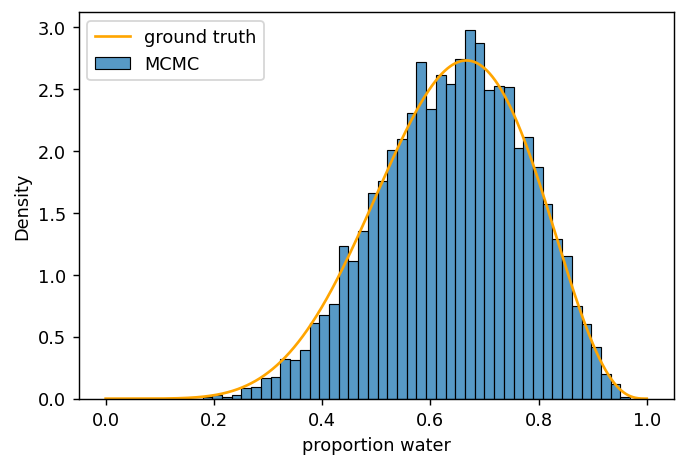

In [24]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=128)

ax = sns.histplot(samples, stat="density", ax=ax)
ax = sns.lineplot(x=x, y=true_line, ax=ax, color="orange")
ax.legend(["ground truth", "MCMC"]);
ax.set_xlabel("proportion water");